In [1]:
import warnings

warnings.filterwarnings("ignore")

from common_utils.utils.config import Config
from common_utils.io.data_access.data_access_factory import DataAccessFactory

# from axpo_trading.forecast.forecast_preprocess_iberia import preproces_ufis
from common_utils.utils import utils, utils_io, utils_date
from axpo_trading.forecast import forecast_sql_preprocess_iberia
from axpo_trading.forecast import forecast_preprocess_iberia
import pandas as pd
import numpy as np
import os
import datetime
from numpy import array
import matplotlib.pyplot as plt

# Random seeds
from numpy.random import seed

seed(42)
from tensorflow.keras.utils import set_random_seed

set_random_seed(42)
import random as rn

rn.seed(1254)
from keras.metrics import RootMeanSquaredError, MeanAbsoluteError

# wind_path = os.path.abspath(os.path.join(os.getcwd(), os.pardir, os.pardir))
wind_path = "/home/jovyan/projects/AdvancedAnalytics-UseCase-Wind"
os.chdir(wind_path)

os.environ["CONFIG_DIR"] = "config_files"
os.environ["AUTH_CONFIG_DIR"] = "auth"
os.environ["AZURE_STORAGE_ACCOUNT_RAW_CONTAINER_NAME_WIND_RAW"] = "raw"
os.environ["AZURE_STORAGE_ACCOUNT_RAW_CONTAINER_NAME_WIND_STAGING"] = "staging"
os.environ[
    "AZURE_SQL_SHARED_RAW_SERVER"
] = "axso-prod-appl-aa-prod-shared-sql-secondary.database.windows.net"
# os.environ["AZURE_SQL_SHARED_RAW_SERVER"] = 'axso-prod-appl-aa-prod-shared-sql.database.windows.net'
os.environ["AZURE_SQL_SHARED_RAW_DATABASE"] = "axso-prod-appl-aa-prod-shared-raw-sqldb"
os.environ["N_THREADS_SQL"] = "1"

# DEV
os.environ["ENV"] = "azure_iberia_k8s_dev"
# BLOB DEV
os.environ["AZURE_STORAGE_ACCOUNT_DATA_NAME"] = "axsonpaadevdslabdls"
os.environ["AZURE_STORAGE_ACCOUNT_RAW_NAME"] = "axsoprodaaprodshareddls-secondary"
os.environ["AZURE_STORAGE_ACCOUNT_DATA_CONTAINER_NAME_WIND_REFINED"] = "wind-refined"
os.environ["AZURE_STORAGE_ACCOUNT_DATA_CONTAINER_NAME_WIND_RESULTS"] = "wind-results"

In [2]:
date_from_train = "2019-01-01"
date_to_train = "2022-05-01"
# date_from_train = "2021-01-01"
# date_to_train = "2021-05-20"

date_from_validate = "2022-05-02"
date_to_validate = "2022-06-01"

date_from_test = "2022-06-02"
date_to_test = "2022-07-02"

n_steps_in = 12
n_steps_out = 3

portfolio_level = True

main_premaster_columns = ["datetime_market","datetime","hours_fwd","ufi","telemetry","forecast","metering"]
info_columns = ["telemetry","forecast","metering","forecast_error_metering","forecast_error_telemetry"]
groupping_columns = ['ufi','hours_fwd']
target_hours_fwd = [1,2,3]
# target_ufis = ["ZAPATER","PEARBO","ROMERA"]
# target_ufis = ["ABELLA","PAXAMON","SPADRON","PELALIN","TIGUEIR","PEIRIXO","MONTCEO","MONTOUT"]
target_ufis= ['ABELLA', 'CERROS', 'LAMESA', 'LACAYA', 'VILACHA', 'TIGUEIR',
       'ESQUILE', 'BRULLES', 'PELALIN', 'PESLOB', 'VISOS', 'DEFERII',
       'PECORTI', 'LASORDA', 'ESCANDO', 'BAYO', 'HINOJII',
       'PEOCHAO', 'CALERA', 'CPELAOS', 'ELGALLO', 'SPADRON', 'PAXAMON',
       'TRAPERA', 'SABUCED', 'PEZARZU', 'PESLOA', 'ASNEVES', 'CAMPANA',
       'PECOUTE', 'HINOJAI', 'PESLOD', 'AXIABRE', 'FEIXOS', 'OTERO',
       'POTRA', 'ZARZUEL', 'CERCEDA', 'GRAIADE', 'PEOUROL', 'RODERA',
       'MONTOUT', 'ARTEIXO', 'ELLLAN', 'MONTCEO', 'LALOMBA', 'CARRACE',
       'PEIRIXO', 'ATALAYA', 'FRAILA', 'DEHESII', 'MONTERO', 'MONDONE',
       'ROMERA', 'ESE', 'BANDELE', 'SANJOSE', 'SERRETA', 'DEHEII',
       'AEROGEN', 'ZAPATER', 'LARUYA', 'PESLOC', 'PEARBO', 'PELALOM',
       'MUDEFER']

### Load function

In [3]:
def pivot_master_by_levels(multiple_line_df):

    # TODO Parametrize levels

    # Pivot data according to level
    # Level 1: market dependent columns
    index_cols = ["datetime_market"]
    market_level_columns = ["hour_market"]
    reduced_df_lv_1 = multiple_line_df[market_level_columns + index_cols]
    reduced_df_lv_1["day_market"] = multiple_line_df["datetime_market"].dt.day
    reduced_df_lv_1["month_market"] = multiple_line_df["datetime_market"].dt.month
    # Add missing levels to even the final shapes
    reduced_df_lv_1 = reduced_df_lv_1.drop_duplicates()
    reduced_df_lv_1 = reduced_df_lv_1.set_index(index_cols, drop=True)
    even_level_1_arrays = [
        market_level_columns + ["day_market", "month_market"],
        [""],
        [""]
    ]
    reduced_df_lv_1.columns = pd.MultiIndex.from_product(even_level_1_arrays, names=["feature", "ufi", "hours_fwd"])

    # Level 2: ufi dependent columns
    index_cols = index_cols + ["ufi"]
    ufi_level_columns = ["p_max", "p_min", "telemetry", "telemetry_pct_good", "telemetry_open", "telemetry_close", "telemetry_min", "telemetry_max", "telemetry_std", "telemetry_value_count", "telemetry_slope"] # "codCliente", "up", 
    reduced_df_lv_2 = multiple_line_df[ufi_level_columns + index_cols]
    reduced_df_lv_2 = reduced_df_lv_2.drop_duplicates(subset=["datetime_market","ufi"])
    reduced_df_lv_2 = reduced_df_lv_2.pivot(index=['datetime_market'], columns=['ufi'], values=ufi_level_columns)
    # Add missing level to even the shapes
    even_level_2_arrays = [
        list(reduced_df_lv_2.columns.get_level_values(0)),
        list(reduced_df_lv_2.columns.get_level_values(1)),
        list([""] * reduced_df_lv_2.columns.shape[0])
    ]
    even_level_2_tuples = list(zip(*even_level_2_arrays))
    reduced_df_lv_2.columns = pd.MultiIndex.from_tuples(even_level_2_tuples, names=["feature", "ufi", "hours_fwd"])
    reduced_df_lv_2

    # Level 3: horizon dependent columns
    index_cols = index_cols + ["hours_fwd"]
    horizon_level_columns = ["forecast","metering"] #,"forecast_error_metering" ,"forecast_error_telemetry"]
    reduced_df_lv_3 = multiple_line_df[horizon_level_columns + index_cols]
    reduced_df_lv_3 = reduced_df_lv_3.drop_duplicates()
    reduced_df_lv_3 = reduced_df_lv_3.pivot(index=['datetime_market'], columns=['ufi','hours_fwd'], values=horizon_level_columns)

    pivotted_df = pd.concat([reduced_df_lv_1,  pd.concat([reduced_df_lv_2, reduced_df_lv_3], axis=1)], axis=1)

    return pivotted_df



def add_forecast_error_pivot(pivot_df, error_reference="telemetry"):

    ufis_in_df = pivot_df.columns.get_level_values("ufi").unique()
    # Remove empty ufi used for even levels
    ufis_in_df = [ufi for ufi in ufis_in_df if ufi]
    fcst_error_df = pd.DataFrame()
    fcst_error_df_partial = pd.DataFrame()

    for ufi in ufis_in_df:

        if error_reference == "telemetry":
            # Telemetry aligned with index hour (it comes with 1 hour lag)
            telemetry_market_t = pivot_df[error_reference,ufi].shift(-1)
            # Forecasted production aligned with the index hour (we take the t+1 forecast)
            forecast_market_t = pivot_df["forecast",ufi,1].shift(1)
            fcst_error_df_partial[f"forecast_error_{error_reference}"] = forecast_market_t - telemetry_market_t
            # Lag the forecast error 1 hour so it is available at prediction time
            fcst_error_df_partial[f"forecast_error_{error_reference}"] = fcst_error_df_partial[f"forecast_error_{error_reference}"].shift(1)
        else:
            # Error with respect to Metering  which is already aligned
            metering_market_t = pivot_df[error_reference,ufi,1]
            forecast_market_t = pivot_df["forecast",ufi,1]
            fcst_error_df_partial[f"forecast_error_{error_reference}"] = forecast_market_t - metering_market_t
            # Lag the forecast error 1 hour so it is available at prediction time
            fcst_error_df_partial[f"forecast_error_{error_reference}"] = fcst_error_df_partial[f"forecast_error_{error_reference}"]


        fcst_error_df_partial["ufi"] = ufi
        fcst_error_df = pd.concat([fcst_error_df, fcst_error_df_partial])

    fcst_error_df = fcst_error_df.pivot(columns=['ufi'], values=[f"forecast_error_{error_reference}"])

    # Add missing level to even the shapes
    even_level_2_arrays = [
        list(fcst_error_df.columns.get_level_values(0)),
        list(fcst_error_df.columns.get_level_values(1)),
        list([""] * fcst_error_df.columns.shape[0])
    ]
    even_level_2_tuples = list(zip(*even_level_2_arrays))
    fcst_error_df.columns = pd.MultiIndex.from_tuples(even_level_2_tuples, names=["feature", "ufi", "hours_fwd"])

    return pd.concat([fcst_error_df, pivot_df], axis=1)


def get_master(date_from, date_to, cols_to_keep, horizons, ufis, values_to_pivot, do_pivot=True):

    # Load premaster data
    config_dict = Config.get_config()
    factory = DataAccessFactory()
    data_config = config_dict["data_access_factory"]
    source = factory.get(data_config["master_overcost"]["source"])

    master = utils_io.load_monthly(
        path=f"forecast/research/premaster_eolic",
        date_col="date",
        date_from=date_from,
        date_to=date_to,
        data_access=source,
    )

    # Get sample of premaster
    if cols_to_keep == "all":
        cols_to_keep = master.columns
    reduced_df = master[cols_to_keep]
    # Get only info for the next three hours
    reduced_df = reduced_df[reduced_df["hours_fwd"].isin(horizons)]
    # Get only records for target ufis
    reduced_df = reduced_df[reduced_df["ufi"].isin(ufis)][cols_to_keep]
    # Drop columns with empty meterings
    reduced_df = reduced_df[reduced_df['metering'].notna()]
    # Add forecast_error_predict_time
#     reduced_df["forecast_error_metering"] = reduced_df["forecast"] - reduced_df["metering"]

    # The telemetry is not aligned with the forecast thus we cannot simply subtract
    #     reduced_df["forecast_error_telemetry"] = reduced_df["forecast"] - reduced_df["telemetry"]

    # ?Drop rows with empty forecast error since we cannot know their real values 
    reduced_df = reduced_df.drop_duplicates()
    if do_pivot:
        pivot_df = pivot_master_by_levels(reduced_df)
    else:
        return reduced_df

    # Now we can align the forecasts and telemetry at market time to get the recent forecast error
    pivot_df = add_forecast_error_pivot(pivot_df, error_reference="telemetry")
    pivot_df = add_forecast_error_pivot(pivot_df, error_reference="metering")

    # It's really important to determine the order of the columns since we will be working with their array representation, not the dataframe
    pivot_df = pivot_df.sort_index(axis='columns', level=[0,1,2])

    return pivot_df



### Load data and pivot

In [4]:
date_first = "2018-12-31"
date_last = "2022-10-31"
master_complete = get_master(date_first, date_last, cols_to_keep="all", horizons=target_hours_fwd, ufis=target_ufis, values_to_pivot=info_columns)
master_complete = master_complete.sort_index()
print()

2023-02-09 11:52:54,853 - MainThread - [INFO] - b'[UTILS IO] - load_monthly at line 176: Loading monthly from : forecast/research/premaster_eolic'
2023-02-09 11:52:54,891 - MainThread - [INFO] - b'[UTILS IO] - format_dates at line 465: 2018-12-31'
2023-02-09 11:52:55,047 - MainThread - [INFO] - b"[UTILS IO] - filter_files_load_monthly at line 448: Files in path: ['premaster_eolic___202107_0.h5', 'premaster_eolic___201910_0.h5', 'premaster_eolic___202101_0.h5', 'premaster_eolic___201909_0.h5', 'premaster_eolic___202005_0.h5', 'premaster_eolic___201905_0.h5', 'premaster_eolic___202002_0.h5', 'premaster_eolic___202006_0.h5', 'premaster_eolic___202007_0.h5', 'premaster_eolic___202110_0.h5', 'premaster_eolic___201912_0.h5', 'premaster_eolic___202205_0.h5', 'premaster_eolic___202206_0.h5', 'premaster_eolic___202208_0.h5', 'premaster_eolic___202210_0.h5', 'premaster_eolic___201908_0.h5', 'premaster_eolic___202108_0.h5', 'premaster_eolic___202001_0.h5', 'premaster_eolic___202204_0.h5', 'premas

/home/jovyan/my-conda-envs/windTFM/lib/python3.7/site-packages/tables/__init__.py:93: DeprecationWarning:

`np.typeDict` is a deprecated alias for `np.sctypeDict`.

/home/jovyan/my-conda-envs/windTFM/lib/python3.7/site-packages/tables/req_versions.py:20: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

/home/jovyan/my-conda-envs/windTFM/lib/python3.7/site-packages/tables/req_versions.py:21: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

/home/jovyan/my-conda-envs/windTFM/lib/python3.7/site-packages/tables/req_versions.py:22: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

/home/jovyan/my-conda-envs/windTFM/lib/python3.7/site-packages/tables/req_versions.py:23: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

/home/jovyan/my-conda-envs/windTFM/lib/python3.7/site-packages/tables/req_versions.py:24: Depre

2023-02-09 11:53:00,210 - MainThread - [INFO] - b'[UTILS IO] - get_files_without_sampling at line 398: Reading file premaster_eolic___201902_0.h5'
2023-02-09 11:53:04,264 - MainThread - [INFO] - b'[UTILS IO] - get_files_without_sampling at line 398: Reading file premaster_eolic___201903_0.h5'
2023-02-09 11:53:08,900 - MainThread - [INFO] - b'[UTILS IO] - get_files_without_sampling at line 398: Reading file premaster_eolic___201904_0.h5'
2023-02-09 11:53:13,699 - MainThread - [INFO] - b'[UTILS IO] - get_files_without_sampling at line 398: Reading file premaster_eolic___201905_0.h5'
2023-02-09 11:53:18,449 - MainThread - [INFO] - b'[UTILS IO] - get_files_without_sampling at line 398: Reading file premaster_eolic___201906_0.h5'
2023-02-09 11:53:23,047 - MainThread - [INFO] - b'[UTILS IO] - get_files_without_sampling at line 398: Reading file premaster_eolic___201907_0.h5'
2023-02-09 11:53:27,759 - MainThread - [INFO] - b'[UTILS IO] - get_files_without_sampling at line 398: Reading file pr

In [5]:
master_train = get_master(date_from_train, date_to_train, cols_to_keep="all", horizons=target_hours_fwd, ufis=target_ufis, values_to_pivot=info_columns)
master_validate = get_master(date_from_validate, date_to_validate, cols_to_keep="all", horizons=target_hours_fwd, ufis=target_ufis, values_to_pivot=info_columns)
master_test = get_master(date_from_test, date_to_test, cols_to_keep="all", horizons=target_hours_fwd, ufis=target_ufis, values_to_pivot=info_columns)


2023-02-09 11:58:44,416 - MainThread - [INFO] - b'[UTILS IO] - load_monthly at line 176: Loading monthly from : forecast/research/premaster_eolic'
2023-02-09 11:58:44,455 - MainThread - [INFO] - b'[UTILS IO] - format_dates at line 465: 2019-01-01'
2023-02-09 11:58:44,551 - MainThread - [INFO] - b"[UTILS IO] - filter_files_load_monthly at line 448: Files in path: ['premaster_eolic___202107_0.h5', 'premaster_eolic___201910_0.h5', 'premaster_eolic___202101_0.h5', 'premaster_eolic___201909_0.h5', 'premaster_eolic___202005_0.h5', 'premaster_eolic___201905_0.h5', 'premaster_eolic___202002_0.h5', 'premaster_eolic___202006_0.h5', 'premaster_eolic___202007_0.h5', 'premaster_eolic___202110_0.h5', 'premaster_eolic___201912_0.h5', 'premaster_eolic___202205_0.h5', 'premaster_eolic___202206_0.h5', 'premaster_eolic___202208_0.h5', 'premaster_eolic___202210_0.h5', 'premaster_eolic___201908_0.h5', 'premaster_eolic___202108_0.h5', 'premaster_eolic___202001_0.h5', 'premaster_eolic___202204_0.h5', 'premas

### DF to NP MATRIX

In [6]:
def split_sequences(sequences, n_steps_in, n_steps_out, target_col, portfolio_level=True):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences.iloc[i:end_ix, :], sequences.iloc[end_ix:out_end_ix, :]

        # As a feature we have forecast error based on telemetry (real time proxy for meterings)
        seq_x = seq_x.rename(columns={"forecast_error_telemetry":"forecast_error"})
        # As a target we want the forecast error to be the based on the actual metering
        seq_y = seq_y.rename(columns={"forecast_error_metering":"forecast_error"})

        # Drop the spare forecast error and original meterings
        seq_x = seq_x.drop(["forecast_error_metering","metering"], axis=1)

        # OPTION 1. Predict all input time series
        # seq_y = seq_y.drop(["forecast_error_telemetry","metering"], axis=1)
        # OPTION 2. Predict only target col for each UFI
        seq_y = seq_y[target_col]
        # OPTION 3. Predict only taget col for complete Portfolio
        if portfolio_level:
            seq_y = seq_y.sum(axis=1)

        # Flatten col levels
        flatten_cols_x = ["-".join(str(cs) for cs in c) for c in seq_x.columns.to_series()]
        seq_x.columns = flatten_cols_x
        if not portfolio_level:
            flatten_cols_y = ["-".join(str(cs) for cs in c) for c in seq_y.columns.to_series()]
            seq_y.columns = flatten_cols_y

        X.append(seq_x.values)
        y.append(seq_y.values)

    X_arr = array(X)
    y_arr = array(y)

    if portfolio_level:
        y_arr = y_arr[:,:, np.newaxis]

    return X_arr, y_arr

In [7]:
# Convert into numpy format
master_train = master_train.sort_index()
X_train, y_train = split_sequences(master_train, n_steps_in, n_steps_out, target_col="forecast_error", portfolio_level=portfolio_level)

In [8]:
# Convert into numpy format
master_validate = master_validate.sort_index()
X_validate, y_validate = split_sequences(master_validate, n_steps_in, n_steps_out, target_col="forecast_error", portfolio_level=portfolio_level)

In [9]:
# Convert into numpy format
master_test = master_test.sort_index()
X_test, y_test = split_sequences(master_test, n_steps_in, n_steps_out, target_col="forecast_error", portfolio_level=portfolio_level)

### DL Model

In [10]:
import keras
import tensorflow as tf
from keras import Input, Model, metrics
from keras import Input, Model, metrics
from keras.layers import Dense, RepeatVector, LSTM, TimeDistributed, Dropout
from sklearn.preprocessing import StandardScaler, MinMaxScaler

class EO_LSTM():

    def __init__(self, train_x, train_y, valid_x, valid_y, test_x, test_y):

        self.n_features_in = train_x.shape[2]
        self.n_features_out = train_y.shape[2]
        self.n_steps_in = train_x.shape[1]
        self.n_steps_out = train_y.shape[1]

        self.train_x = train_x
        self.train_y = train_y
        self.valid_x = valid_x
        self.valid_y = valid_y
        self.test_x = test_x
        self.test_y = test_y

        self.test_x_scaler_dict = {}
        self.test_y_scaler_dict = {}

    def scale_data(self, ts_arr, train=True, target=False):

        if target:
            scaler_dict = self.test_y_scaler_dict
        else:
            scaler_dict = self.test_x_scaler_dict

        # Scale each time series separately
        for col_i in np.arange(0,ts_arr.shape[2]):
            if train:
                new_scaler = MinMaxScaler()
                ts_arr[:,:,col_i] = new_scaler.fit_transform(ts_arr[:,:,col_i])
                scaler_dict[col_i] = new_scaler
            else:
                existing_scaler = scaler_dict[col_i]
                ts_arr[:,:,col_i] = existing_scaler.transform(ts_arr[:,:,col_i])

        if target:
            self.test_y_scaler_dict = scaler_dict
        else:
            self.test_x_scaler_dict = scaler_dict

        return ts_arr

    def unscale_predictions(self, pred_arr):
        scaler_dict = self.test_y_scaler_dict
        for col_i in np.arange(0,pred_arr.shape[2]):
            scaler_obj = scaler_dict[col_i]
            pred_arr[:,:,col_i] = scaler_obj.inverse_transform(pred_arr[:,:,col_i])
        return pred_arr

    def get_model(self):
        input_layer = Input(shape=(self.n_steps_in,self.n_features_in), name='input_layer')
        lstm_1 = LSTM(30, activation='relu', name="LSTM_Layer_1")(input_layer)
        repeat_vector = RepeatVector(self.n_steps_out, name="Repeating_Vector_Layer")(lstm_1)
        lstm_2 = LSTM(30, activation='relu', return_sequences=True, name="LSTM_Layer_2")(repeat_vector)
        lstm_3 = LSTM(10, activation='relu', return_sequences=True, name="LSTM_Layer_3")(lstm_2)
        dense = Dense(self.n_features_out, activation="relu",name='Dense_Layer')
        dropout = Dropout(.3, input_shape=(2,))(lstm_3)
        time_dist = TimeDistributed(dense, name='Time_Distributed_Layer')(dropout)

        model = Model(inputs=input_layer, outputs=time_dist)
        model.compile(optimizer='adam', loss='mean_squared_error', metrics=[metrics.mse])
        self.model = model
        return self.model

    def train(self, epochs=1, scale_data=True):

        log_dir = "tensor_logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

        if scale_data:
            train_x = self.scale_data(self.train_x)
            train_y = self.scale_data(self.train_y, target=True)
            valid_x = self.scale_data(self.valid_x, train=False)
            valid_y = self.scale_data(self.valid_y, train=False, target=True)
        else:
            train_x = self.train_x
            train_y = self.train_y
            valid_x = self.valid_x
            valid_y = self.valid_y

        train_x = np.nan_to_num(train_x, nan=-1)
        train_y = np.nan_to_num(train_y, nan=-1)
        valid_x = np.nan_to_num(valid_x, nan=-1)
        valid_y = np.nan_to_num(valid_y, nan=-1)

        hist = self.model.fit(train_x, train_y, validation_data=(valid_x, valid_y), epochs=epochs, batch_size=150, verbose=1, callbacks=[tensorboard_callback])
        self.hist = hist
        return hist

    def predict(self, data, scale_data=True):
        # print(f"Desc of predicted data BEFORE SCALING is: {pd.DataFrame(data[:,1,:]).describe().loc['mean',:3]}")
        if scale_data:
            data = self.scale_data(data, train=False, target=False)
        #  print(f"Desc of predicted data is: {pd.DataFrame(data[:,1,:]).describe().loc['mean',:3]}")
        data = np.nan_to_num(data, nan=-1)
        predicted = self.model.predict(data)
        predicted = np.where(predicted == -1, np.nan, predicted)

        if scale_data:
            predicted = self.unscale_predictions(predicted)

        return predicted


In [11]:
lstm1 = EO_LSTM(X_train, y_train, X_validate, y_validate, X_test, y_test)

2023-02-09 17:28:40.243349: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-02-09 17:28:40.243418: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-09 17:28:40.243456: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jupyter-diaz-20martinez-20antonio-20de-20padua-20axpoes-20admin): /proc/driver/nvidia/version does not exist
2023-02-09 17:28:40.244023: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


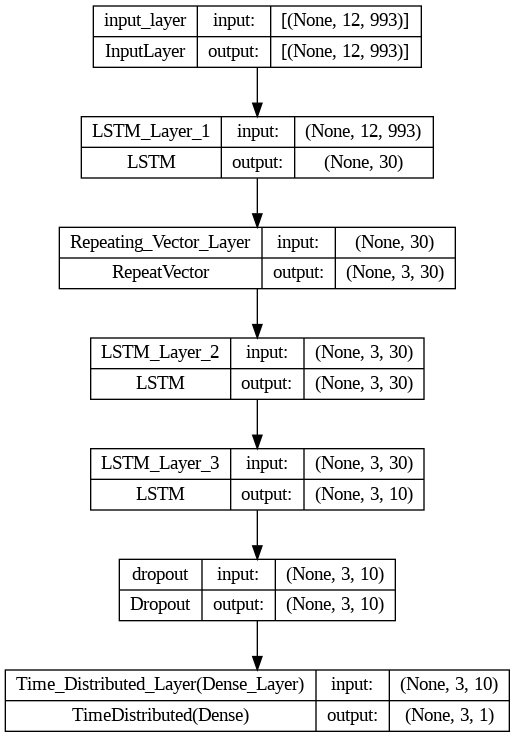

In [13]:
from tensorflow.keras.utils import plot_model
lstm1.get_model()

plot_model(lstm1.model, to_file='lstm_plot.png', show_shapes=True, show_layer_names=True)

In [15]:
from keras_visualizer import visualizer 
visualizer(lstm1.model, format='png', view=True)

ValueError: Keras Visualizer: Layer not supported for visualizing

In [12]:
lstm1.get_model()
lstm1.model.summary()

epochs_count = 100
# for epoch in range(epochs_count):
hist = lstm1.train(epochs=epochs_count)

2022-12-29 18:50:55.704141: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-12-29 18:50:55.704203: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-29 18:50:55.704231: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jupyter-diaz-20martinez-20antonio-20de-20padua-20axpoes-20admin): /proc/driver/nvidia/version does not exist
2022-12-29 18:50:55.704609: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 24, 993)]         0         
                                                                 
 LSTM_Layer_1 (LSTM)         (None, 30)                122880    
                                                                 
 Repeating_Vector_Layer (Rep  (None, 5, 30)            0         
 eatVector)                                                      
                                                                 
 LSTM_Layer_2 (LSTM)         (None, 5, 30)             7320      
                                                                 
 LSTM_Layer_3 (LSTM)         (None, 5, 10)             1640      
                                                                 
 dropout (Dropout)           (None, 5, 10)             0         
                                                             

dict_keys(['loss', 'mean_squared_error', 'val_loss', 'val_mean_squared_error'])


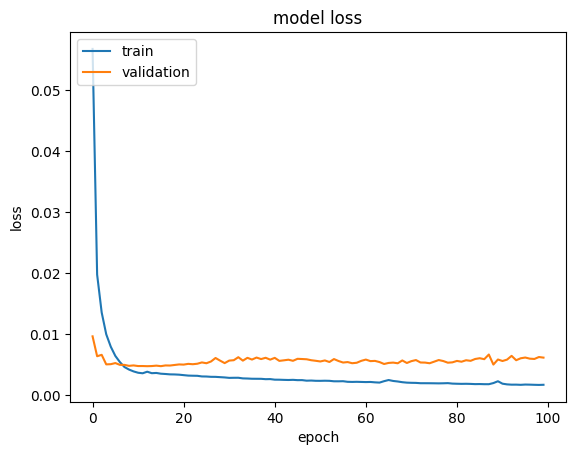

In [13]:
import matplotlib.pyplot as plt
hist = lstm1.hist
# list all data in history
print(hist.history.keys())
# summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [14]:
predictions = lstm1.predict(X_test.copy())
predictions2 = lstm1.predict(X_test.copy())

23/23 [==============================] - 0s 6ms/step


In [15]:
predictions

array([[[-10.518492],
        [ -7.640846],
        [  2.620681],
        [ 10.84471 ],
        [ 17.287731]],

       [[ 23.474741],
        [ 21.43381 ],
        [ 31.063877],
        [ 43.352276],
        [ 51.587482]],

       [[ 28.368103],
        [ 27.245447],
        [ 39.901897],
        [ 55.194016],
        [ 65.22206 ]],

       ...,

       [[ 22.698683],
        [ 24.585264],
        [ 40.076046],
        [ 55.696415],
        [ 64.53614 ]],

       [[ 38.63226 ],
        [ 39.113605],
        [ 47.998196],
        [ 55.351322],
        [ 58.568245]],

       [[ 55.175064],
        [ 54.72515 ],
        [ 54.174976],
        [ 51.935684],
        [ 49.172234]]], dtype=float32)

In [16]:
predictions.shape

(718, 5, 1)

## Format predictions into dataframe

In [17]:
_, y_forecast = split_sequences(master_test, n_steps_in, n_steps_out, target_col="forecast")
print(y_forecast.shape)

(718, 5, 1)


In [80]:
# Get col schema for raw predictions
master_test_format = master_test.rename(columns={"forecast_error_metering":"forecast_error"}).copy()
# Deprecated since now we only use the forecast as target
# premaster_pivot_test = premaster_pivot_test.drop(["forecast_error_telemetry","metering"], axis=1)
# prediction_col_schema = premaster_pivot_test.columns
if portfolio_level:
    master_test_format["forecast_error_portfolio"] = master_test_format["forecast_error"].sum(axis=1)
    prediction_col_schema = ["forecast_error_portfolio"]
    forecast_col_schema = ["forecast_portfolio"]
else:
    prediction_col_schema = master_test_format["forecast_error"].columns
    # Get col schema for forecasts to compute imbalances
    forecasts_formatted = master_test.loc[:, (slice("forecast"), slice(None), slice(None))]
    forecast_col_schema = forecasts_formatted["forecast"].columns

horizons = np.arange(0, n_steps_out)

predictions_formatted = pd.DataFrame()
test_set_formatted = pd.DataFrame()
forecast_set_formatted = pd.DataFrame()
predictions_t = pd.DataFrame()
for t_plus in horizons:
    head_offset = n_steps_in+t_plus
    tail_offset = -n_steps_out+t_plus+1
    if tail_offset == 0:
        tail_offset = None

    # Predictions
    predictions_t = pd.DataFrame(predictions[:,t_plus,:], columns=prediction_col_schema)
    predictions_t.index = master_test_format.index[head_offset:tail_offset]

    if t_plus == horizons[0]:
        predictions_formatted = predictions_t
    else:
        predictions_formatted = predictions_formatted.join(predictions_t, rsuffix=f"_t{t_plus+1}")

    # True values
    test_t = pd.DataFrame(y_test[:,t_plus,:], columns=prediction_col_schema)
    test_t.index = master_test_format.index[head_offset:tail_offset]

    if t_plus == horizons[0]:
        test_set_formatted = test_t
    else:
        test_set_formatted = test_set_formatted.join(test_t, rsuffix=f"_t{t_plus+1}")

    # Forecast
    forecast_t = pd.DataFrame(y_forecast[:,t_plus,:], columns=forecast_col_schema)
    forecast_t.index = master_test_format.index[head_offset:tail_offset]

    if t_plus == horizons[0]:
        forecast_set_formatted = forecast_t
    else:
        forecast_set_formatted = forecast_set_formatted.join(forecast_t, rsuffix=f"_t{t_plus+1}")



In [19]:
# if portfolio_level:
#     master_test_format["forecast_portfolio"] = master_test_format.loc[:, (slice("forecast"), slice(None), slice(None))].sum(axis=1)
#     forecast_set_formatted = master_test_format["forecast_portfolio"]
# else:
#     forecast_set_formatted = master_test["forecast"]

# forecast_set_formatted = forecast_set_formatted[forecast_set_formatted.index.isin(predictions_formatted.index)]

In [20]:
forecast_set_formatted.head()

,forecast_portfolio,forecast_portfolio_t2,forecast_portfolio_t3,forecast_portfolio_t4,forecast_portfolio_t5
2022-06-02 21:00:00,539.500000,NaN,NaN,NaN,NaN
2022-06-02 22:00:00,473.400024,473.400024,NaN,NaN,NaN
2022-06-02 23:00:00,402.600037,402.600037,402.600037,NaN,NaN
2022-06-03 00:00:00,329.299988,329.299988,329.299988,329.299988,NaN
2022-06-03 01:00:00,267.500000,267.500000,267.500000,267.500000,267.5


In [21]:
test_set_formatted.head()

,forecast_error_portfolio,forecast_error_portfolio_t2,forecast_error_portfolio_t3,forecast_error_portfolio_t4,forecast_error_portfolio_t5
2022-06-02 21:00:00,16.418001,NaN,NaN,NaN,NaN
2022-06-02 22:00:00,-0.035994,-0.035994,NaN,NaN,NaN
2022-06-02 23:00:00,-59.685005,-59.685005,-59.685005,NaN,NaN
2022-06-03 00:00:00,-30.051001,-30.051001,-30.051001,-30.051001,NaN
2022-06-03 01:00:00,13.382000,13.382000,13.382000,13.382000,13.382


In [22]:
predictions_formatted.head()

,forecast_error_portfolio,forecast_error_portfolio_t2,forecast_error_portfolio_t3,forecast_error_portfolio_t4,forecast_error_portfolio_t5
2022-06-02 21:00:00,-10.518492,NaN,NaN,NaN,NaN
2022-06-02 22:00:00,23.474741,-7.640846,NaN,NaN,NaN
2022-06-02 23:00:00,28.368103,21.433809,2.620681,NaN,NaN
2022-06-03 00:00:00,29.868986,27.245447,31.063877,10.844710,NaN
2022-06-03 01:00:00,51.417294,27.895029,39.901897,43.352276,17.287731


## Measure Accuracy (Imbalance in MWh, MAE)


### Portfolio level

In [23]:
from keras.metrics import RootMeanSquaredError, MeanAbsoluteError

rmse = RootMeanSquaredError()
mae = MeanAbsoluteError()

cols_to_report = ["ufi"] + list(horizons)

imbalance_row = ["portfolio"]
accuracy_row_mae = ["portfolio"]

imbalance_report = pd.DataFrame()
accuracy_report_mae = pd.DataFrame()

for t in horizons:

    if t == 0:
        suffix = ""
    else:
        suffix = f"_t{t+1}"

    prediction_forecast_error_metering = predictions_formatted.iloc[:,t].values
    test_set_forecast_error_metering = test_set_formatted.iloc[:,t].values

    # Due to the way we query the forecasts there are gaps which result in nan values
    baseline_forecast = forecast_set_formatted.iloc[:,t].values
    non_null_indices = np.argwhere(~np.isnan(baseline_forecast))
    # Filter out data without target info
    baseline_forecast = baseline_forecast[non_null_indices]
    prediction_forecast_error_metering = prediction_forecast_error_metering[non_null_indices]
    test_set_forecast_error_metering = test_set_forecast_error_metering[non_null_indices]

    expected_forecast = baseline_forecast + prediction_forecast_error_metering
    true_forecast = baseline_forecast + test_set_forecast_error_metering

    baseline_imbalance = np.sum(true_forecast) - np.sum(baseline_forecast)
    expected_imbalance = np.sum(true_forecast) - np.sum(expected_forecast)
    delta_imbalance = np.abs(baseline_imbalance) - np.abs(expected_imbalance)

    mae_ufi_t = mae(test_set_forecast_error_metering,prediction_forecast_error_metering).numpy()

    imbalance_row = imbalance_row + [delta_imbalance]
    accuracy_row_mae = accuracy_row_mae + [mae_ufi_t]

imbalance_report = imbalance_report.append(pd.Series(imbalance_row, index=cols_to_report), ignore_index=True)
accuracy_report_mae = accuracy_report_mae.append(pd.Series(accuracy_row_mae, index=cols_to_report), ignore_index=True)



In [24]:
imbalance_report

,0,1,2,3,4,ufi
0,-19711.0625,-18727.5,-18593.8125,-18167.75,-17697.8125,portfolio


In [25]:
accuracy_report_mae

,0,1,2,3,4,ufi
0,50.877728,50.648895,50.427433,50.248352,50.164181,portfolio


### Ufi level

In [29]:
from keras.metrics import RootMeanSquaredError, MeanAbsoluteError
rmse = RootMeanSquaredError()
mae = MeanAbsoluteError()

cols_to_report = ["ufi"] + list(horizons)

imbalance_report = pd.DataFrame()
accuracy_report_mae = pd.DataFrame()

ufis_in_df = master_test.columns.get_level_values("ufi").unique()
# Remove empty ufi used for even levels
ufis_in_df = [ufi for ufi in ufis_in_df if ufi]

horizons = np.arange(0,n_steps_out)

for ufi in ufis_in_df:

    imbalance_row = [ufi]
    accuracy_row_mae = [ufi]

    for t in horizons:

        if t == 0:
            suffix = ""
        else:
            suffix = f"_t{t+1}"

        prediction_forecast_error_metering = predictions_formatted[ufi+suffix].values
        test_set_forecast_error_metering = test_set_formatted[ufi+suffix].values

        # Due to the way we query the forecasts there are gaps which result in nan values
        baseline_forecast = forecast_set_formatted[ufi].iloc[:,t].values # 
        non_null_indices = np.argwhere(~np.isnan(test_set_forecast_error_metering))
        # Filter out data without target info
        baseline_forecast = baseline_forecast[non_null_indices]
        prediction_forecast_error_metering = prediction_forecast_error_metering[non_null_indices]
        test_set_forecast_error_metering = test_set_forecast_error_metering[non_null_indices]

        expected_forecast = baseline_forecast + prediction_forecast_error_metering
        true_forecast = baseline_forecast + test_set_forecast_error_metering

        baseline_imbalance = np.sum(true_forecast) - np.sum(baseline_forecast)
        expected_imbalance = np.sum(true_forecast) - np.sum(expected_forecast)
        delta_imbalance = np.abs(baseline_imbalance) - np.abs(expected_imbalance)

        mae_ufi_t = mae(test_set_forecast_error_metering,prediction_forecast_error_metering).numpy()

        imbalance_row = imbalance_row + [delta_imbalance]
        accuracy_row_mae = accuracy_row_mae + [mae_ufi_t]

    imbalance_report = imbalance_report.append(pd.Series(imbalance_row, index=cols_to_report), ignore_index=True)
    accuracy_report_mae = accuracy_report_mae.append(pd.Series(accuracy_row_mae, index=cols_to_report), ignore_index=True)


KeyError: 'ABELLA'

In [179]:
imbalance_report

,0,1,2,ufi
0,-1813.526855,-2446.937256,-3725.699951,ABELLA
1,-1933.415771,-2833.729004,-4049.176025,MONTCEO
2,-693.471436,-1358.947021,-1851.747070,MONTOUT
3,-1091.042725,-1686.673828,-2293.121826,PAXAMON
4,-1845.508179,-2966.216797,-3150.548828,PEIRIXO
5,-1745.627808,-2891.331055,-3316.416992,PELALIN
6,-2119.746582,-3077.418213,-4175.028320,SPADRON
7,-1633.750732,-1917.020386,-3376.215820,TIGUEIR


In [180]:
accuracy_report_mae

,0,1,2,ufi
0,6.007477,6.927936,8.396859,ABELLA
1,7.660330,7.726591,8.336402,MONTCEO
2,7.962811,7.880792,7.972257,MONTOUT
3,7.686838,7.597358,7.652405,PAXAMON
4,7.576857,7.724126,7.884646,PEIRIXO
5,7.702408,7.729235,7.820128,PELALIN
6,7.720358,7.764796,7.951323,SPADRON
7,7.803641,7.703137,7.781116,TIGUEIR


## Second draft for accuracy

In [138]:
baseline_forecast = test_set_formatted["forecast"+suffix][ufi][1].values
non_null_indices = np.argwhere(~np.isnan(baseline_forecast))

In [12]:
# Determine the length of one feature in columns
ufis_in_df = master_validate.columns.get_level_values("ufi").unique()
n_target_ufis = len(ufis_in_df)
hours_fwd_in_df = master_validate.columns.get_level_values("hours_fwd").unique()
n_target_hours_fwd = len(hours_fwd_in_df)
feature_len = n_target_ufis * n_target_hours_fwd

horizons = np.arange(0,n_steps_out)
column_order = master_test.columns.get_level_values(0).unique()
prediction_cols = ["forecast","forecast_error_metering","telemetry"]
ordered_prediction_cols = [col for col in column_order if col in prediction_cols]
--------------------------
t_plus = horizons[0]
# Format t+1
head_offset = n_steps_in+t_plus
tail_offset = -n_steps_out+t_plus+1
if tail_offset == 0:
    tail_offset = None

predictions_t1 = pd.DataFrame(predictions[:,t_plus,:], columns=pd.MultiIndex.from_product([ordered_prediction_cols,ufis_in_df, hours_fwd_in_df], names=["feature","ufi","hours_fwd"]))
# predictions_t1.index = master_test.index[n_steps_in:-n_steps_out+1]
predictions_t1.index = master_test.index[head_offset:tail_offset]

test_t1 = pd.DataFrame(y_test[:,t_plus,:], columns=pd.MultiIndex.from_product([ordered_prediction_cols,ufis_in_df, hours_fwd_in_df], names=["feature","ufi","hours_fwd"]))
test_t1.index = master_test.index[head_offset:tail_offset]
# test_t1.index = master_test.index[n_steps_in+t_plus:-n_steps_out+1]


# Format t+2
t_plus = horizons[1]

head_offset = n_steps_in+t_plus
tail_offset = -n_steps_out+t_plus+1
if tail_offset == 0:
    tail_offset = None
    
predictions_t2 = pd.DataFrame(predictions[:,t_plus,:], columns=pd.MultiIndex.from_product([ordered_prediction_cols,ufis_in_df, hours_fwd_in_df], names=["feature","ufi","hours_fwd"]))
predictions_t2.index = master_test.index[head_offset:tail_offset]
# predictions_t2.index = master_test.index[n_steps_in+t_plus:-n_steps_out+1]

test_t2 = pd.DataFrame(y_test[:,t_plus,:], columns=pd.MultiIndex.from_product([ordered_prediction_cols,ufis_in_df, hours_fwd_in_df], names=["feature","ufi","hours_fwd"]))
# test_t2.index = master_test.index[n_steps_in:-n_steps_out+1]
test_t2.index = master_test.index[head_offset:tail_offset]

# pd.DataFrame(predictions[:,0,forecast_error_indexes[0]:forecast_error_indexes[1]], columns=pd.MultiIndex.from_product([["forecast_error"],ufis_in_df, hours_fwd_in_df], names=["feature","ufi","hours_fwd"]))
# pd.DataFrame(predictions[:,0,forecast_indexes[0]:forecast_indexes[1]], columns=pd.MultiIndex.from_product([["forecast"],ufis_in_df, hours_fwd_in_df], names=["feature","ufi","hours_fwd"]))
# pd.DataFrame(predictions[:,0,telemetry_indexes[0]:telemetry_indexes[1]], columns=pd.MultiIndex.from_product([["telemetry"],ufis_in_df, hours_fwd_in_df], names=["feature","ufi","hours_fwd"]))


In [13]:
predictions_t1["forecast_error_metering"]["ABELLA"]

hours_fwd,1.0,2.0,3.0
datetime_market,,,
2021-09-02 09:00:00,0.000000,0.000000,0.282224
2021-09-02 10:00:00,0.021707,0.000000,0.330420
2021-09-02 11:00:00,0.035305,0.000000,0.278176
2021-09-02 12:00:00,0.089023,0.000000,0.177475
2021-09-02 13:00:00,0.220740,0.000000,0.036173
...,...,...,...
2021-10-01 14:00:00,0.219324,0.164961,0.000000
2021-10-01 15:00:00,0.295203,0.256642,0.000000
2021-10-01 16:00:00,0.295420,0.224697,0.000000


In [14]:
test_t1["forecast_error_metering"]["ABELLA"][1]

datetime_market
2021-09-02 09:00:00    0.995
2021-09-02 10:00:00    0.800
2021-09-02 11:00:00    0.700
2021-09-02 12:00:00    0.423
2021-09-02 13:00:00    0.732
                       ...  
2021-10-01 14:00:00    1.150
2021-10-01 15:00:00    0.471
2021-10-01 16:00:00   -1.876
2021-10-01 17:00:00   -1.232
2021-10-01 18:00:00   -1.561
Name: 1.0, Length: 706, dtype: float32

In [15]:
from keras.metrics import RootMeanSquaredError, MeanAbsoluteError
rmse = RootMeanSquaredError()
mae = MeanAbsoluteError()

ufi_name = "ABELLA"

mae.update_state(test_t1["forecast_error_metering"][ufi_name][1].values,predictions_t1["forecast_error_metering"][ufi_name][1].values)
print(f"------MAE: {mae.result().numpy()}")
rmse.update_state(test_t1["forecast_error_metering"][ufi_name][1].values,predictions_t1["forecast_error_metering"][ufi_name][1].values)
print(f"------RMSE: {rmse.result().numpy()}")

# Due to the way we query the forecasts there are gaps which result in nan values
baseline_forecast = test_t1["forecast"][ufi_name][1].values
expected_forecast = baseline_forecast + predictions_t1["forecast_error_metering"][ufi_name][1].values
true_forecast = baseline_forecast + test_t1["forecast_error_metering"][ufi_name][1].values

non_null_indices = np.argwhere(~np.isnan(baseline_forecast))
baseline_forecast = baseline_forecast[non_null_indices]
expected_forecast = expected_forecast[non_null_indices]
true_forecast = true_forecast[non_null_indices]

print(f"Baseline production imbalance: {np.sum(true_forecast) - np.sum(baseline_forecast)}") # Equal to the baseline_forecast
print(f"Expected production imbalance: {np.sum(true_forecast) - np.sum(expected_forecast)}")
print(f"True production: {np.sum(true_forecast)}")
print("\n")

------MAE: 1.5640171766281128
------RMSE: 2.305093765258789
Baseline production imbalance: -488.89013671875
Expected production imbalance: -583.03857421875
True production: 2240.60986328125




In [18]:
rmse_2 = RootMeanSquaredError()
mae_2 = MeanAbsoluteError()

mae_2.update_state(test_t2["forecast_error_metering"][ufi_name][1].values,predictions_t2["forecast_error_metering"][ufi_name][1].values)
print(f"------MAE: {mae_2.result().numpy()}")
rmse_2.update_state(test_t2["forecast_error_metering"][ufi_name][1].values,predictions_t2["forecast_error_metering"][ufi_name][1].values)
print(f"------RMSE: {rmse_2.result().numpy()}")

# Due to the way we query the forecasts there are gaps which result in nan values
baseline_forecast = test_t2["forecast"][ufi_name][1].values
expected_forecast = baseline_forecast + predictions_t2["forecast_error_metering"][ufi_name][1].values
true_forecast = baseline_forecast + test_t2["forecast_error_metering"][ufi_name][1].values

non_null_indices = np.argwhere(~np.isnan(baseline_forecast))
baseline_forecast = baseline_forecast[non_null_indices]
expected_forecast = expected_forecast[non_null_indices]
true_forecast = true_forecast[non_null_indices]

print(f"Baseline production imbalance: {np.sum(true_forecast) - np.sum(baseline_forecast)}") # Equal to the baseline_forecast
print(f"Expected production imbalance: {np.sum(true_forecast) - np.sum(expected_forecast)}")
print(f"True production: {np.sum(true_forecast)}")
print("\n")

------MAE: 1.5417464971542358
------RMSE: 2.2733335494995117
Baseline production imbalance: -491.27294921875
Expected production imbalance: -510.8125
True production: 2239.72705078125




## First draft for accuracy

In [313]:
# output_sample_n = np.arange(0,predictions.shape[0])
# t_plus_sample = [0,1]
# t_plus_absolute = output_sample_n + t_plus_sample

# groupping_columns: ufi, hours_fwd
# Determine the length of one feature in columns
ufis_in_df = master_validate.columns.get_level_values("ufi").unique()
n_target_ufis = len(ufis_in_df)
hours_fwd_in_df = master_validate.columns.get_level_values("hours_fwd").unique()
n_target_hours_fwd = len(hours_fwd_in_df)
feature_len = n_target_ufis * n_target_hours_fwd

# Determine indices for each feature
column_order = master_validate.columns.get_level_values(0).unique()
# Get the indexes for each feature based on config data
forecast_idx_start = column_order.get_loc("forecast") * feature_len
# forecast_indexes = [0,10]
forecast_indexes = [forecast_idx_start, forecast_idx_start + feature_len]

forecast_error_idx_start = column_order.get_loc("forecast_error_metering") * feature_len
# forecast_error_indexes = [10,20]
forecast_error_indexes = [forecast_error_idx_start,forecast_error_idx_start + feature_len]

telemetry_idx_start = column_order.get_loc("telemetry") * feature_len
# telemetry_indexes = [20]
telemetry_indexes = [telemetry_idx_start, telemetry_idx_start + feature_len]

# Extract predicted and true data
y_pred_forecast_error = predictions[:,:,forecast_error_indexes[0]:forecast_error_indexes[1]]
# y_true_forecast_error = y_test_masked[:,:,forecast_error_indexes[0]:forecast_error_indexes[1]]
# y_true_baseline_forecast = y_test_masked[:,:,forecast_indexes[0]:forecast_indexes[1]]
# y_test_masked has -1 values where Nans should go so the results are biased, we have to use the orginal y_test

# Target: forecast error of the baseline when compared to the actual metering
y_true_forecast_error = y_test_masked[:,:,forecast_error_indexes[0]:forecast_error_indexes[1]]
# Forecast received from the client which is combined with our forecast error predictions to get the actual forecast
y_true_baseline_forecast = y_test[:,:,forecast_indexes[0]:forecast_indexes[1]]


In [314]:
from keras.metrics import RootMeanSquaredError, MeanAbsoluteError
rmse = RootMeanSquaredError()
mae = MeanAbsoluteError()

# Calculate one-hour-ahead forecasts since further horizons (that is, the rest of hours forward) 
# we want to obtain from the corresponding n_steps_out 
for t in np.arange(0,n_steps_out):
    print(f"PREDICTIONS FOR T+{t+1}:")

    for j in np.arange(0,n_target_ufis):
        print(f"ufi: {ufis_in_df[j]}")

        for i in np.arange(0,n_target_hours_fwd):
            offset = j * n_target_hours_fwd
            print(f"Hours_fwd: {i+1}")

            # Get accuracy against target variable
            
            mae.update_state([y_true_forecast_error[:,t,i+offset]],[y_pred_forecast_error[:,t,i+offset]])
            print(f"------MAE: {mae.result().numpy()}")
            rmse.update_state([y_true_forecast_error[:,t,i+offset]],[y_pred_forecast_error[:,t,i+offset]])
            print(f"------RMSE: {rmse.result().numpy()}")

            # Get accuracy against baseline
            baseline_forecast = y_true_baseline_forecast[:,t,i+offset]
            expected_forecast = baseline_forecast + y_pred_forecast_error[:,t,i+offset]
            true_forecast = baseline_forecast + y_true_forecast_error[:,t,i+offset]

            # Due to the way we query the forecasts there are gaps which result in nan values
            non_null_indices = np.argwhere(~np.isnan(baseline_forecast))
            baseline_forecast = baseline_forecast[non_null_indices]
            expected_forecast = expected_forecast[non_null_indices]
            true_forecast = true_forecast[non_null_indices]

            print(f"Baseline production imbalance: {np.sum(true_forecast) - np.sum(baseline_forecast)}") # Equal to the baseline_forecast
            print(f"Expected production imbalance: {np.sum(true_forecast) - np.sum(expected_forecast)}")
            print(f"True production: {np.sum(true_forecast)}")
            print("\n")


PREDICTIONS FOR T+1:
ufi: PESLOD
Hours_fwd: 1
------MAE: 2.3927879333496094
------RMSE: 3.946267604827881
Baseline production imbalance: 230.348876953125
Expected production imbalance: -662.386474609375
True production: 4040.848876953125


Hours_fwd: 2
------MAE: 2.4230756759643555
------RMSE: 3.9459333419799805
Baseline production imbalance: 273.91357421875
Expected production imbalance: -478.65087890625
True production: 4132.61376953125


Hours_fwd: 3
------MAE: 2.4718315601348877
------RMSE: 3.988234758377075
Baseline production imbalance: 299.013916015625
Expected production imbalance: -442.69775390625
True production: 4182.81396484375


ufi: SABUCED
Hours_fwd: 1
------MAE: 2.074336528778076
------RMSE: 3.5217385292053223
Baseline production imbalance: 89.2459716796875
Expected production imbalance: 85.0279541015625
True production: 2123.446044921875


Hours_fwd: 2
------MAE: 1.8350045680999756
------RMSE: 3.2116129398345947
Baseline production imbalance: 87.6641845703125
Expected 